In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt  
from copy import deepcopy
from preprocessing import Preprocess

In [2]:
dataset = pd.read_csv('exchange_rate.txt',header=None)

In [3]:
data = dataset[dataset.shape[0]-2000:dataset.shape[0]-24*9]

In [4]:
data1 = data.values

In [5]:
#data = data1[:,[0, 61, 147, 241]]
data = data1[:,:4]

In [6]:
data.shape

(1784, 4)

In [7]:
#Basic informations 

num_predictors = 70
num_input = 15
lag = 24*3
lag_notused = np.array([[4,5],[4,5],[4],[4,5]])
not_used_lag = False
h_prev = 24
#Actually, lag stands for all inputs for each serie. Example, lag = 2 uses s(t) and s(t-1) to predict s(t+1)
diff_series = False
detrend_series = False

#bin_values = 12; #Representação da binarização do tempo.
num_series = data.shape[1]  #Numero de series do problema, extraído dos dados

max_rulesize = 4 #Max numbers of premises rules.
min_activation = 0.6 #Minimum activation

#####Definicao de funcoes######
#detrend_method = ''
#bin_method = ''

fuzzy_method = 'mfdef_cluster'
num_groups = 9

defuzz_method = 'cog'

ensemble_rules = None

total_number = data.shape[1]*lag


filepath = 'exchange-rate'



In [8]:
preprocess_data = Preprocess(data,h_prev=h_prev,num_series=num_series)

In [9]:
in_sample, out_sample = preprocess_data.split_data()
yt, yp, yp_lagged = preprocess_data.delay_input(in_sample = in_sample, lag = lag)

In [10]:
yt.shape

(1687, 4)

In [11]:
dataset[000:]

,0,1,2,3,4,5,6,7
0,0.785500,1.611000,0.861698,0.634196,0.211242,0.006838,0.593000,0.525486
1,0.781800,1.610000,0.861104,0.633513,0.211242,0.006863,0.594000,0.523972
2,0.786700,1.629300,0.861030,0.648508,0.211242,0.006975,0.597300,0.526316
3,0.786000,1.637000,0.862069,0.650618,0.211242,0.006953,0.597000,0.523834
4,0.784900,1.653000,0.861995,0.656254,0.211242,0.006940,0.598500,0.527426
...,...,...,...,...,...,...,...,...
7583,0.718494,1.222195,0.737485,0.969974,0.143697,0.008500,0.690846,0.688565
7584,0.721839,1.223459,0.741155,0.977297,0.143763,0.008595,0.695701,0.690288
7585,0.723197,1.234111,0.745184,0.984446,0.143997,0.008562,0.695943,0.691419
7586,0.720825,1.233905,0.744131,0.980344,0.143993,0.008555,0.692689,0.690942


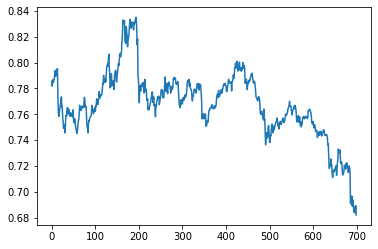

In [12]:
plt.plot(dataset[0][0:700])

In [13]:
import seaborn as sns
from copy import deepcopy
from utils import *

import itertools
import json
import os

#For e-autoMFIS, we import all of them.
from autoMFIS import *
import numpy as np
import scipy.io
from reweight import Reweight
from fuzzyfication import Fuzzification
from defuzzification import Defuzzification
import matplotlib.pyplot as plt
from predict import predict



def convert_object_to_float(data,datanames):
    
    for name in datanames:
        dname = data[name].values.astype('str')
        dname = [new_value.replace(',','.') for new_value in dname]
        data[name] = dname
        data[name] = data[name].astype(float)
    return data

##Assertion for ensemble rules
#Somehow, when appending rules, ensemble_rules[:,1] has a erroneous form. This part seems to normalize it.

#This module correct this error. Also, we are going to use some assertion to check if rules contains the same antecedents.
def correct_bug(ensemble_rules,max_rulesize=0):
    correct_rule = []
    d_stacked_rules = []
    new_ensemble_rules = np.zeros(shape=ensemble_rules.shape, dtype=object)


    for  n_times in range(ensemble_rules.shape[1]):
        t_rules = ensemble_rules[:,n_times]
        correct_rule = []
        d_stacked_rules = []
        k = 0
        for rule in t_rules:
            #print(rule)
            #print(len(rule))
            #Check if there's a rule bigger than max_rulesize + 1 (#antecedents + #consequent)
            if len(rule) > max_rulesize + 1:
                #print(rule)
                for i in rule:
                    #k += 1
                    if isinstance(i,tuple):
                        #print(i)
                        correct_rule.append(i)
                    else:
                        if len(correct_rule) == 0:
                            #print(i)
                            pass
                            #d_stacked_rules.append(i)
                        else:
                            #print(correct_rule)
                            new_ensemble_rules[k,n_times] = correct_rule
                            k += 1
                            #d_stacked_rules.append(correct_rule)
                            correct_rule = []
                            #d_stacked_rules.append(i)
            else:
                new_ensemble_rules[k,n_times] = rule
                k += 1
                #d_stacked_rules.append(rule)
            
        #new_ensemble_rules[:,i] = np.array(d_stacked_rules)

    return new_ensemble_rules

def remove_duplicates(new_ensemble_rules,ensemble_prem_terms, ensemble_antecedents):
    t_rules = deepcopy(new_ensemble_rules[:,0])
    no_duplicated_ensemble = np.zeros(new_ensemble_rules.shape,dtype=object)
    no_duplicated_prem_terms = np.zeros(ensemble_prem_terms.shape)
    no_duplicated_antecedents = np.zeros(ensemble_antecedents.shape,dtype=object)
    new_t_rules = None

    k = 0
    j = 0
    for rule in t_rules:
        if new_t_rules is None:
            new_t_rules = [rule]
            no_duplicated_ensemble[k,:] = deepcopy(new_ensemble_rules[j,:])
            no_duplicated_prem_terms[k,:] = deepcopy(ensemble_prem_terms[j,:])
            no_duplicated_antecedents[k,:] = deepcopy(ensemble_antecedents[j,:])
            k += 1

        elif not check_duplicate_rules(rule,new_t_rules):
            new_t_rules.append(rule)
            no_duplicated_ensemble[k,:] = deepcopy(new_ensemble_rules[j,:])
            no_duplicated_prem_terms[k,:] = deepcopy(ensemble_prem_terms[j,:])
            no_duplicated_antecedents[k,:] = deepcopy(ensemble_antecedents[j,:])
            k += 1
        j += 1

    new_rules = deepcopy(no_duplicated_ensemble[:k,:])
    new_prem_terms = deepcopy(no_duplicated_prem_terms[:k,:])
    new_antecedents = deepcopy(no_duplicated_antecedents[:k,:])

    return new_rules, new_prem_terms, new_antecedents



In [14]:
'''
t = [a + n for n in range(0,data.shape[0]-168,168) for a in range(24)]
t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]
yp = deepcopy(yp[t_lagged,:])
yt = deepcopy(yt[t_lagged,:])
yp_lagged = deepcopy(yp_lagged[t_lagged,:])

data = deepcopy(data[t[len(t)-len(t_lagged):],:])
in_sample = data[:data.shape[0]-h_prev,:]
out_sample = data[data.shape[0]-h_prev:,:]

print(len(t_lagged))
'''

'\nt = [a + n for n in range(0,data.shape[0]-168,168) for a in range(24)]\nt_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]\nyp = deepcopy(yp[t_lagged,:])\nyt = deepcopy(yt[t_lagged,:])\nyp_lagged = deepcopy(yp_lagged[t_lagged,:])\n\ndata = deepcopy(data[t[len(t)-len(t_lagged):],:])\nin_sample = data[:data.shape[0]-h_prev,:]\nout_sample = data[data.shape[0]-h_prev:,:]\n\nprint(len(t_lagged))\n'

In [15]:
###############Fuzzificacao

Fuzzyfy = Fuzzification(fuzzy_method)

#Lembrete: 
#axis 0 - Registros da série
#axis 1 - Valor de pertinência ao conjunto Fuzzy
#axis 2 - Numero de séries

first_time = True
for n in range(num_series):
    
    _, mf_params = Fuzzyfy.fuzzify(in_sample[:,n],np.array([]),num_groups=num_groups)
    mX, _ = Fuzzyfy.fuzzify(yp[:,n],mf_params,num_groups=num_groups)
    mY, _ = Fuzzyfy.fuzzify(yt[:,n],mf_params,num_groups=num_groups)
    if first_time:
        mX_ = np.ndarray([mX.shape[0],mX.shape[1], num_series])
        mY_ = np.ndarray([mY.shape[0],mY.shape[1], num_series])
        mf_params_ = np.ndarray([mf_params.shape[0],num_series])
        first_time = False
    mX_[:,:,n] = mX
    mY_[:,:,n] = mY
    mf_params_[:,n] = mf_params.ravel()
    #print(mf_params)
    #print(mX.shape)


mX_lagged_ = np.ndarray([mX_.shape[0],mX_.shape[1],yp_lagged.shape[1]])
for i in range(num_series):
    mf_params = mf_params_[:,i]
    for j in range(lag):
        mX, _ = Fuzzyfy.fuzzify(yp_lagged[:,i*lag+j],mf_params,num_groups=num_groups)
        mX_lagged_[:,:,i*lag+j] = mX
        #print(i*lag+j)


#mX_lagged_[:,:,not_select_subsample] = 0

#print(mX_lagged_[:,:,not_select_subsample])
############## Formulacao
if not_used_lag:
    new_mX, lags_used = remove_lags(mX_lagged_,lag_notused,num_series,lag)
else:
    new_mX = mX_lagged_


#Concatenate rules
for i in range(num_predictors):
    not_select_subsample = np.random.choice(total_number,total_number-num_input,replace=False)
    #try:
    complete_rules, prem_terms, rules, agg_training, wd_ = autoMFIS(data,lag=lag, lag_notused=lag_notused, not_used_lag=not_used_lag,not_select_subsample=not_select_subsample, h_prev = h_prev, diff_series=diff_series, detrend_series=detrend_series, num_series=num_series, max_rulesize=max_rulesize, min_activation=min_activation, fuzzy_method=fuzzy_method, num_groups=num_groups,solve_method='mqr',defuzz_method=defuzz_method,yt=yt,yp=yp,yp_lagged=yp_lagged,in_sample=in_sample,out_sample=out_sample)
    print('Predict number {}'.format(i))
    #Prediction of a single subset
    errors = predict(Fuzzyfy, lags_used = [], num_groups=num_groups, ndata=dataset, data=data,in_sample=in_sample,out_sample=out_sample, lag = lag, mf_params_=mf_params_,num_series=num_series,agg_training=agg_training,yp_lagged=yp_lagged,h_prev=h_prev,not_used_lag=not_used_lag,n_attempt='subsample_{}'.format(i),wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules,filepath=filepath,lim=3.0,defuzz_method=defuzz_method,fig_axis=[2,2])
    #print(errors)
    #print(complete_rules)
    if errors[0,0] < 0.02:
        if ensemble_rules is None:
            ensemble_rules = complete_rules
            ensemble_prem_terms = prem_terms
            ensemble_antecedents = rules
            #print(ensemble_rules.shape)
        else:
            ensemble_rules = np.concatenate((ensemble_rules, complete_rules))
            
            ensemble_prem_terms = np.concatenate((ensemble_prem_terms,prem_terms))
            ensemble_antecedents = np.concatenate((ensemble_antecedents,rules))
            print(ensemble_rules.shape)
            print(ensemble_prem_terms.shape)
        #print(ensemble_rules[:,0])
    print('RMSE Errors = {}'.format(errors[0,:]))
    print('RRSE Errors = {}'.format(errors[1,:]))
    print('Mean RRSE Error = {}'.format(np.mean(errors[1,:])))

    #except Exception as e:
    #    print(e)
    #    pass

new_ensemble_rules = correct_bug(ensemble_rules,max_rulesize=max_rulesize)

new_rules, new_prem_terms, new_antecedents = remove_duplicates(new_ensemble_rules,ensemble_prem_terms, ensemble_antecedents)

rw = Reweight(mY_,new_rules,new_prem_terms)
wd_, agg_training = rw.run('mqr',debug=False)

predict(Fuzzyfy, lags_used = [], num_groups=num_groups, ndata=dataset, data=data,in_sample=in_sample,out_sample=out_sample, lag = lag, mf_params_=mf_params_,num_series=num_series,agg_training=agg_training,yp_lagged=yp_lagged,h_prev=h_prev,not_used_lag=not_used_lag,n_attempt='_{}'.format(i),wd_=wd_,ensemble_antecedents=new_antecedents,ensemble_rules=new_rules,filepath=filepath,lim=3.0,defuzz_method=defuzz_method,fig_axis=[2,2])

NameError: name 'fuzzy_method' is not defined

In [16]:
#rw = Reweight(mY_,complete_rules,prem_terms)
#wd_, agg_training = rw.run('mqr',debug=False)
#defuzz = Defuzzification(mf_params_,num_series)
#y_predict_ = defuzz.run('mom',agg_training,show=True)

In [17]:
plt.plot(y_predict_[:,0])
plt.plot(in_sample[:,0])
plt.yticks(np.arange(0,0.5,0.03))

NameError: name 'y_predict_' is not defined

In [18]:
m = max(a)
mom = [i for i,j in enumerate(a) if j==m]
print('MoM = {}'.format(0.5*(mom[0]+mom[-1])))

NameError: name 'a' is not defined

In [19]:
plt.plot(data)

NameError: name 'data' is not defined

In [20]:
data2 = dataset.values

NameError: name 'dataset' is not defined

In [21]:
plt.plot(data2[timestamps,0])

NameError: name 'data2' is not defined

In [22]:
for i in range(30,40):
    plt.figure()
    for t in timestamps:
        plt.plot(data2[t,i])

NameError: name 'timestamps' is not defined